In [71]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pygad
from pygad import torchga

In [72]:
input_layer = torch.nn.Linear(28*28, 50)
relu = torch.nn.ReLU()
dense_layer = torch.nn.Linear(50, 10)
softmax = torch.nn.Softmax(1)

model = torch.nn.Sequential(input_layer,
                            relu,
                            dense_layer,
                            softmax)

In [61]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [62]:
import numpy as np

In [63]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

In [64]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size= 10000, 
                                          shuffle=True,
                                          num_workers = 1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True)
}
for batch_idx, (data, target) in enumerate(loaders['train']):
    data_inputs = data
    data_outputs = target

In [65]:
def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function
    data_inputs = data_inputs.view(-1, 28*28) 
    predictions = pygad.torchga.predict(model=model,
                                        solution=solution,
                                        data=data_inputs)
    predictions_no_grad = predictions.detach()
    solution_fitness = 1.0 / (loss_function(predictions_no_grad , data_outputs).numpy() + 0.00000001)
    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

In [73]:
##model.load_state_dict(torch.load(PATH))
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=100)

loss_function = torch.nn.CrossEntropyLoss()

In [74]:
initial_population = torch_ga.population_weights # Initial population of network weights.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=100,
                       sol_per_pop=100,
                       crossover_type="two_points",
                       parent_selection_type="rank",
                       mutation_percent_genes = 20,
                       num_parents_mating=4,
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)


Generation = 1
Fitness    = 0.44250849967677786
Generation = 2
Fitness    = 0.44250849967677786
Generation = 3
Fitness    = 0.44642604917691076
Generation = 4
Fitness    = 0.45223210408563397
Generation = 5
Fitness    = 0.45409914201118445
Generation = 6
Fitness    = 0.4549341408445911
Generation = 7
Fitness    = 0.4672711615549518
Generation = 8
Fitness    = 0.4673375955650537
Generation = 9
Fitness    = 0.4679577057110167
Generation = 10
Fitness    = 0.46896580189298503
Generation = 11
Fitness    = 0.47211599346402217
Generation = 12
Fitness    = 0.4753297466024688
Generation = 13
Fitness    = 0.4753297466024688
Generation = 14
Fitness    = 0.4753297466024688
Generation = 15
Fitness    = 0.4790029398084219
Generation = 16
Fitness    = 0.47910186446729214
Generation = 17
Fitness    = 0.47910186446729214
Generation = 18
Fitness    = 0.47910186446729214
Generation = 19
Fitness    = 0.47910186446729214
Generation = 20
Fitness    = 0.4799347660842389
Generation = 21
Fitness    = 0.4799347

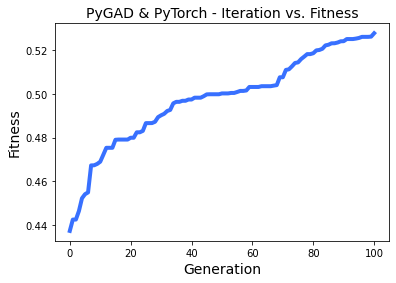

Fitness value of the best solution = 0.5277312457122235
Index of the best solution : 8
Crossentropy :  1.8949039
Accuracy :  0.5656


In [75]:

# Start the genetic algorithm evolution.
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                        weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)

print("Crossentropy : ", loss_function(predictions, data_outputs).detach().numpy())

# Calculate the classification accuracy for the trained model.
accuracy = torch.sum(torch.max(predictions, axis=1).indices == data_outputs) / len(data_outputs)
print("Accuracy : ", accuracy.detach().numpy())

In [76]:
total = 0
correct = 0
for k, (data, target) in enumerate(loaders['test']):
    data = data.view(-1, 28*28)
    
    outputs = model(data)
    predicted = torch.argmax(outputs.data, dim = 1)
    
    correct += (predicted == target).sum().item()
    total += target.size(0)
print(correct/total)

0.556


In [8]:
PATH = 'gaModel.pth'
torch.save(model.state_dict(), PATH)

In [14]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [77]:
def accuracy_by_num(model, test_data):
    fails = np.zeros(10) # Network's mistakes by number
    nums = np.zeros(10) # Amount of each number

    for i, (data, target) in enumerate(test_data):
        data = data.view(-1, 28*28)
        outputs = model(data)
        predicted = torch.argmax(outputs.data, dim = 1)
    
    for i, element in enumerate(predicted):
        nums[target[i]] = nums[target[i]] + 1
        if element != target[i]:
            fails[target[i]] = fails[target[i]] + 1

    accuracy_by_num = 1 - np.divide(fails, nums)
    return np.around(accuracy_by_num, 4)

In [78]:
accuracy_by_num(model, loaders['test'])

array([1.    , 1.    , 0.1429, 0.6429, 0.8   , 0.    , 0.8667, 0.75  ,
       0.    , 0.    ])